# Network Linker

Purpose: Create and connect networks to data and to other networks, with broad control of network parameters.

In [1]:
from full_network import full_network
import numpy as np
import externally_provided_currents as currents
from neuronal_plotting import make_raster_plot
from neuronal_plotting import plot_many_neurons_simultaneous

from builder_LIF import build_LIF_network
import copy

import time as time

Set random seed and number of neurons per network:

In [2]:
np.random.seed(2021)

N_generic = 450
N_smaller = 20

Create currents:

In [3]:
steps_height_list_1 = [5, 5,  5, 0, 0, 5,  0, 5] # banded
steps_height_list_2 = [5, 5,  5, 5, 5, 5,  5, 5] # inhibitory 2
steps_height_list_3 = [25, 25,  0, 0, 0, 0,  0, 0] # sensory
steps_height_list_4 = [0, 0,  25, 25, 25, 25,  25, 25] # sensory



current_object_1 = currents.multiply_multi_current_object(
    [currents.I_flat_alternating_steps(magnitude=3, I_dt=100, steps_height_list=steps_height_list_1),
     currents.I_flat_random_targets(N_smaller, magnitude=1.0, density=1.0)])
current_object_2 = currents.multiply_multi_current_object(
    [currents.I_flat_alternating_steps(magnitude=3, I_dt=100, steps_height_list=steps_height_list_2),
     currents.I_flat_random_targets(N_smaller, magnitude=1.0, density=1.0)])
current_object_3 = currents.multiply_multi_current_object(
    [currents.I_flat_alternating_steps(magnitude=3, I_dt=100, steps_height_list=steps_height_list_3),
     currents.I_flat_random_targets(N_generic, magnitude=1.0, density=0.03)])
current_object_4 = currents.multiply_multi_current_object(
    [currents.I_flat_alternating_steps(magnitude=3, I_dt=100, steps_height_list=steps_height_list_4),
     currents.I_flat_random_targets(N_generic, magnitude=1.0, density=0.03)])


external_current_function_1 = current_object_1.function
external_current_function_2 = current_object_2.function
external_current_function_3 = current_object_3.function
external_current_function_4 = current_object_4.function

# extra descriptors for file name and sometimes plot titles; often contains current name
extra_descriptors = current_object_1.name + ';' + current_object_1.extra_descriptors

data_1 = external_current_function_1
data_2 = external_current_function_2
data_3 = external_current_function_3
data_4 = external_current_function_4


# Convert sound data to F.T.


# Time stuff
dt = 0.1
time_start = 0.0
time_total = 800.0
timesteps = int(float(time_total) / dt)  # total number of intervals to evaluate solution at
times_array = np.linspace(time_start, time_start + time_total, timesteps)

Parameters:

In [4]:
use_STDP = False
sensory_subnetwork_args = {
    # Number of neurons
    'N': N_generic,
    'dt': 0.1,  # ms
    'time_start' : 0.0, # ms
    'time_total': time_total,  # ms
    # Synapse density (1 = fully connected, 0 = never any connection)
    'synapse_density': 0.05,
    # Synaptic conductance scaling factor
    'g_syn_max': 2,
    # Delay between presynaptic neuron firing and effect on postsynaptic neuron feeling effect
    'synapse_delay_delta_t': 3.0,  # ms
    # Synaptic time constant
    'tau_syn': 15,  # ms
    # Synaptic Nernst potentials
    # Each presynaptic neuron in this simulation is either inhibitory or excitatory (also known as Dale's Law)
    # Not totally necessary but I'll implement it here anyway
    'E_syn_excitatory': 15,  # arbitrarily decided values
    'E_syn_inhibitory': 0,
    'ei_threshold': 0.85,
    # "excite-inhibit threshold". A number between 0 and 1. Percentage of connections which are inhibitory
    # STDP-related variables
    'use_STDP': use_STDP,  # Control whether STDP is used to adapt synaptic weights or not
    'tau_W': 3,  # ms
    'STDP_scaling': 10.0,
    'R' : 1,
    'C' : 20,  # capacitance; larger C leads to smaller effect of stimulus on a neuron's voltage
    'threshold' : 10,
    'V_reset' : 0,
    'refractory_time' : 50,  # ms
    # Synaptic weight bounds (dimensionless)
    'l_bound' : 0,
    'u_bound' : 5,
    'number_of_stored_most_recent_spikes' : 50,
    'times_array' : times_array
}
banded_network_args = copy.deepcopy(sensory_subnetwork_args)
banded_network_args['ei_threshold'] = 0.0 # all excitatory connections
banded_network_args['N'] = N_smaller
banded_network_args['refractory_time'] = 2 # ms
banded_network_args['synapse_density'] = 0.0 # Synapse density (1 = fully connected, 0 = never any connection)



inhibitory_network_1_args = copy.deepcopy(sensory_subnetwork_args)
inhibitory_network_1_args['ei_threshold'] = 1.0 # all inhibitory connections
inhibitory_network_1_args['N'] = N_smaller
inhibitory_network_1_args['refractory_time'] = 1 # ms
inhibitory_network_1_args['synapse_density'] = 0.0 # Synapse density (1 = fully connected, 0 = never any connection)


inhibitory_network_2_args = copy.deepcopy(sensory_subnetwork_args)
inhibitory_network_2_args['ei_threshold'] = 1.0 # all inhibitory connections
inhibitory_network_2_args['N'] = N_smaller
inhibitory_network_2_args['refractory_time'] = 1 # ms
inhibitory_network_2_args['synapse_density'] = 0.0 # Synapse density (1 = fully connected, 0 = never any connection)

last_network_args = copy.deepcopy(sensory_subnetwork_args)
last_network_args['ei_threshold'] = 0.95 # mostly inhibitory connections
last_network_args['synapse_density'] = 0.01 # mostly inhibitory connections



Build network objects:

In [5]:
# Build network objects
sensory_subnetwork = build_LIF_network(**sensory_subnetwork_args, network_name = 'sensory_subnetwork')#, STDP_method = STDP_function_interior_1)
banded_subnetwork = build_LIF_network(**banded_network_args, network_name = 'banded_subnetwork')#, STDP_method = STDP_function_interior_1)
inhibitory_subnetwork_1 = build_LIF_network(**inhibitory_network_1_args, network_name = 'inhibitory_subnetwork_1')#, STDP_method = STDP_function_interior_1)
inhibitory_subnetwork_2 = build_LIF_network(**inhibitory_network_2_args, network_name = 'inhibitory_subnetwork_2')#, STDP_method = STDP_function_interior_1)
last_subnetwork = build_LIF_network(**last_network_args, network_name = 'last_subnetwork')#, STDP_method = STDP_function_interior_1)

# Create a "full network" object to hold and connect the subnetworks
total_network = full_network()
total_network.set_subnetworks({'banded_subnetwork' : banded_subnetwork,
                               'inhibitory_subnetwork_1' : inhibitory_subnetwork_1,
                               'inhibitory_subnetwork_2': inhibitory_subnetwork_2,
                               'sensory_subnetwork' : sensory_subnetwork
                              })


Connect subnetworks to lab/external stimulus:

In [6]:
# total_network.connect_to_input_data(data_x, network_y); within the total network, uses data_x as stimulus to network_y
total_network.connect_to_input_data(data_1, banded_subnetwork)
total_network.connect_to_input_data(data_2, inhibitory_subnetwork_2)
total_network.connect_to_input_data(data_3, sensory_subnetwork)
total_network.connect_to_input_data(data_4, sensory_subnetwork)

Connect subnetworks to other subnetworks:

In [7]:
# connect_two_networks(network_x, network_y, STDP_method = STDP_function_z); within the total network,
# connects network_x (presyn) to network_y (postsyn), with STDP_function_z
total_network.connect_two_networks(banded_subnetwork, inhibitory_subnetwork_1, synapse_density = 1.0,
                                   l_bound = 0, stats_scale = 5-0, STDP_method = None, g_x_to_y_and_y_to_x = [1,0])
total_network.connect_two_networks(inhibitory_subnetwork_1, inhibitory_subnetwork_2, synapse_density = 1.0,
                                   l_bound = 0, stats_scale = 5-0, STDP_method = None , g_x_to_y_and_y_to_x = [10,0])
total_network.connect_two_networks(inhibitory_subnetwork_2, sensory_subnetwork, synapse_density = 1.0,
                                   l_bound = 0, stats_scale = 5-0, STDP_method = None , g_x_to_y_and_y_to_x = [10,0])
# total_network.connect_two_networks(sensory_subnetwork, last_subnetwork, synapse_density = 0.01,
#                                    l_bound = 0, stats_scale = 5-0, STDP_method = None , g_x_to_y_and_y_to_x = [1,0])


Changes to subnetwork-subnetwork connections:

In [8]:
for a_connection in total_network.list_of_internetwork_synapses:
    internetwork_W = a_connection[2]
    internetwork_W.tau_syn = 2
    internetwork_W.g_syn_max = 100
    internetwork_W.synapse_delay_delta_t_x_to_y = 0
    internetwork_W.synapse_delay_delta_t_x_to_y = 0

Solve system:

In [9]:
# Run all networks simultaneously (with STDP on or off) and output results
print("Running neurons for " + str(timesteps) + " timesteps of size " + str(dt)+"ms ("+str(time_total) +"ms)")
start_time = time.time()
total_network.run(times_array, dt)
print("Program took " + str(round(time.time() - start_time, 2)) + " seconds to run.")

Running neurons for 8000 timesteps of size 0.1ms (800.0ms)
Program took 52.76 seconds to run.


Plot results:

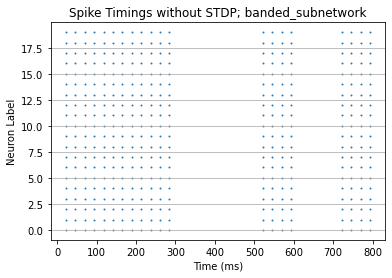

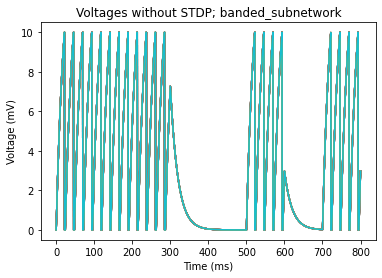

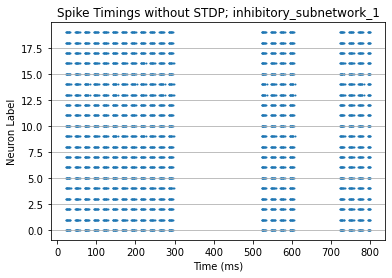

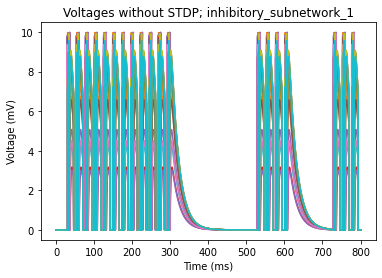

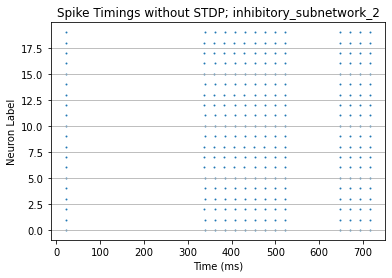

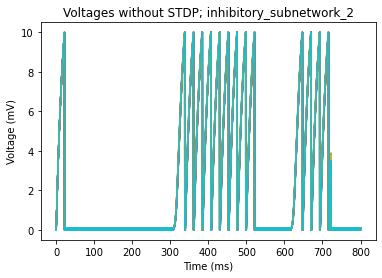

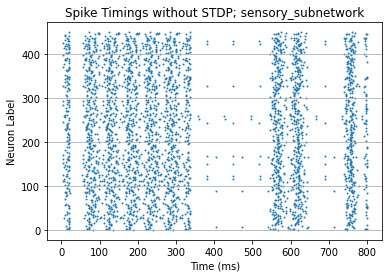

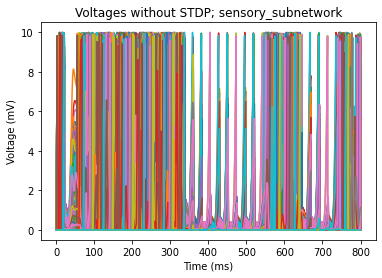

In [10]:
# Process spike results into a more manageable form:
total_results_dict = total_network.organize_results()

# Save and plot subnetwork results for all subnetworks within the full_network:
for subnetwork_name, subnetwork_results in total_results_dict.items():
    V_t, W, times_array, spike_list = subnetwork_results
    N_of_subsystem = total_network.dict_of_networks[subnetwork_name].N
    ########################################################################################################################
    # Saving data
    ########################################################################################################################
    # Save voltage and weights
    np.savetxt('voltages/V_' + str(subnetwork_name)+';STDP=' + str(use_STDP) + ';' + str(extra_descriptors) + '.txt',
               V_t.reshape(timesteps, 1, N_of_subsystem)[:, 0, :], fmt='%.3e')
    np.savetxt('modified_weights/W_' + str(subnetwork_name)+';STDP=' + str(use_STDP) + ';' + str(extra_descriptors) + '.txt',
               W, fmt='%.3e')
    # np.savetxt('spike_data/spike_list_mix;' + extra_descriptors + '.txt', spike_list_to_array(network_mix.N, spike_list), fmt='%.3e')

    # Plot the active neurons
    make_raster_plot(N_of_subsystem, spike_list, use_STDP, extra_descriptors, subnetwork_name=subnetwork_name)
    # Plot the active neurons
    plot_many_neurons_simultaneous(N_of_subsystem, times_array, V_t.reshape(timesteps, 1, N_of_subsystem), use_STDP,
                                   extra_descriptors, subnetwork_name=subnetwork_name)
